In [96]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.transforms as mtransforms


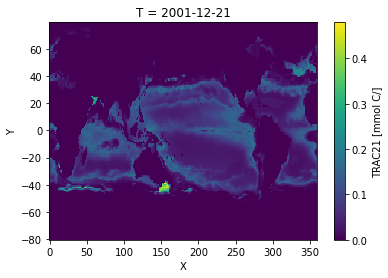

In [102]:
# gluing the tiles together
#opening files, putting each 1/16 of the earth in a list
globe_dss = []
for x_idx in range(1,5):
    for y_idx in range(1,5):
        files = f"/Users/birdy/Documents/eaps_research/darwin3/verification/dar_one_config/run/globe-yr-avg-{x_idx}-{y_idx}/run/ecco_gud_20230208_0001/3d*"
        ds = xr.open_mfdataset(files)
        ds = ds.rename({"Zmd000001":"Z"})
        globe_dss.append(ds)
        
# concatinating datasets together 
y_globe_dss = []
for i in range(0,16, 4):
    ds = xr.concat(globe_dss[i:i+4], dim="Y")
    ds = ds.assign_coords({"Y": range(0, 160)})
    y_globe_dss.append(ds)

ss_ds = xr.concat(y_globe_dss, dim="X")
ss_ds = ss_ds.assign_coords({"X": range(0, 360)})
ss_ds = ss_ds.assign_coords({"Y": range(-80, 80)})

# plot pro, to show that it worked
ss_ds.isel(T=0, Z=0)["TRAC21"].plot()

In [103]:
# load up global ds
file = "/Users/birdy/Documents/eaps_research/gcm_analysis/gcm_data/darwin_weekly_seasonal/3d.nc"
global_ds = xr.open_dataset(file)
global_ds = global_ds.rename({"Zmd000023":"Z"})

# Calculating Bray-Curtis Dissimilarity 

In [104]:
global_ds = global_ds.fillna(0)
ss_ds = ss_ds.fillna(0)

In [105]:
# BC_ij = 1 - (2*C_ij)/(S_i + S_j)
# S_i = sum of all biomass in SS
# S_j = sum of all biomass in global run 
#C_ij = for each organism, sum(min(SS[TRAC21], global[TRAC21]))
def bray_curtis(ss_ds, global_ds):
    # do NOT include diazotrophs 
    tracer_ids = list(range(21,30)) + list(range(35,71))
    s_i = 0
    s_j = 0
    c_list = []
    for i in tracer_ids:
        tracer_name = f"TRAC{i}"
        s_i =  s_i + ss_ds[tracer_name]
        s_j =  s_j + global_ds[tracer_name]
        temp = np.minimum(ss_ds[tracer_name].to_numpy(), global_ds[tracer_name].to_numpy())
        c_list.append(temp)
    c_ij = np.sum(c_list, axis=0)
    top = (2*c_ij)
    bottom = np.sum([s_i, s_j], axis=0)
    ones = np.ones((160, 360))
    bc_ij = ones - top/bottom
    return bc_ij

In [106]:
i_ds = ss_ds.isel(Z=0, T=-1)
j_ds = global_ds.isel(Z=0, T=1)
res = bray_curtis(i_ds, j_ds)

bc_da = xr.DataArray(
    data=res,
    dims=["Y", "X"],
    coords = {"Y":global_ds.Y, "X":global_ds.X})
bc_da

/var/folders/3d/888v68391rv_kgq9_5s8b2x80000gn/T/ipykernel_1758/369424387.py:21: RuntimeWarning: invalid value encountered in true_divide
  bc_ij = ones - top/bottom


<xarray.DataArray (Y: 160, X: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.9761045 , 0.97610883, 0.9758088 , ..., 0.97551665, 0.97453847,
        0.97519398],
       [0.96903918, 0.96740256, 0.9662339 , ..., 0.96709863, 0.96856499,
        0.96953184],
       [0.9523985 , 0.95677661, 0.94906705, ..., 0.94984784, 0.95592978,
        0.95768943]])
Coordinates:
  * Y        (Y) float64 -79.5 -78.5 -77.5 -76.5 -75.5 ... 76.5 77.5 78.5 79.5
  * X        (X) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

# Calculating Diversity Index

In [107]:
# di = s_t / i_t
# s_t = total number of different species
# i_t = total individuals 
def diversity_index(ds):
    # do NOT include diazotrophs 
    tracer_ids = list(range(21,30)) + list(range(35,71))
    s_t = np.zeros((160, 360))
    i_t = np.zeros((160,360))
    for i in tracer_ids:
        tracer_name = f"TRAC{i}"
        has_tracer = ds[tracer_name] > 1e-6
        s_t = s_t + has_tracer
        i_t = i_t + ds[tracer_name]
    di = i_t / s_t
    return di



In [108]:
ss_di = diversity_index(ss_ds.isel(T=-1))
global_di = diversity_index(global_ds.isel(Z=0, T=1))

# Making the Figure 

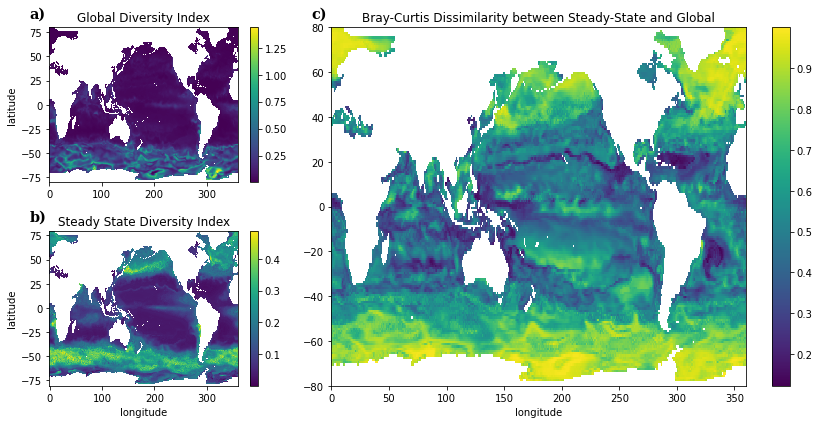

In [112]:
fig = plt.figure(figsize=(12, 6), layout="tight")
gs = fig.add_gridspec(ncols=3, nrows=2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1:])

global_di.plot(ax=ax1)
ax1.set_title("Global Diversity Index")
ax1.set_xlabel(None)
ax1.set_ylabel("latitude")
# ax1.set_title("a)", fontfamily='serif', loc='left', fontsize='x-large', fontweight='bold')

ss_di.plot(ax=ax2)
ax2.set_title("Steady State Diversity Index")
ax2.set_xlabel("longitude")
ax2.set_ylabel("latitude")
# ax2.set_title("b)", fontfamily='serif', loc='left', fontsize='x-large', fontweight='bold')

bc_da.plot(ax=ax3)
ax3.set_title("Bray-Curtis Dissimilarity between Steady-State and Global")
ax3.set_xlabel("longitude")
ax3.set_ylabel(None)

# ax3.set_title("c)", fontfamily='serif', loc='left', fontsize='x-large', fontweight='bold')

for ax, label in [(ax1, "a)"), (ax2, "b)"), (ax3, "c)")]:
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='x-large', va='bottom', fontfamily='serif', fontweight='bold')
    
plt.show()